In [28]:
import pystan as ps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
cwd = os.getcwd()

# Introduction

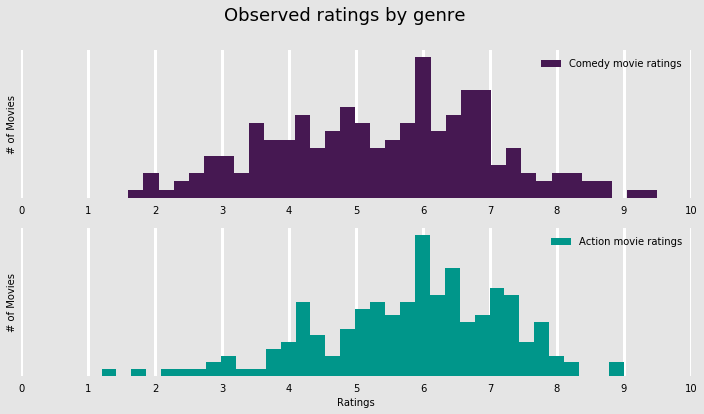

In [284]:
df = pd.read_csv(cwd + "/movies.csv")

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
fig.set_facecolor(color = "#E5E5E5")

axes[0].hist(df[df["genre"] == "Action"]["rating"], bins = 35, color = "#461852", 
             label = "Comedy movie ratings", zorder = 10)
axes[1].hist(df[df["genre"] == "Comedy"]["rating"], bins = 35, color = "#00968A", 
             label = "Action movie ratings", zorder = 10)

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.set_facecolor(color = "#E5E5E5")
    ax.grid(True, which = "major", axis = "x", color = "white", lw = 3, zorder = 0)
    ax.set_xlim(left = 0, right = 10)
    ax.set_xticks(np.arange(0, 11))
    ax.set_yticks([])
    ax. legend(loc='upper right', frameon=False)

axes[0].set_ylabel("# of Movies")
axes[1].set_ylabel("# of Movies")
axes[1].set_xlabel("Ratings")
plt.suptitle("Observed ratings by genre", fontsize = 18)

plt.show()

In [272]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)

    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))
    
def max_repetitions(vec):
    cnts = np.unique(vec, return_counts = True)
    return(np.max(cnts[1]))

def posterior_density(ax, vec, width=.95, c = "#461852"):
    hdi = hpd(pd.np.asarray(vec), 1-width)
    m = np.mean(vec)
    ypos = max_repetitions(vec)/3.0
    ax.scatter(m, ypos, marker = "o", color = "#71CD63", s = 80,
              zorder = 15)
    ax.hist(vec, bins = 35, color = c, zorder = 5)
    ax.hlines(y = ypos,
               xmin = hdi[0], xmax = hdi[1], 
              color = "#71CD63", linewidth=3,
             zorder = 10)
    ax.get_yaxis().set_visible(False)
    return ax

# Modeling

$$
rating_i \sim student\_t(\nu, \mu_i, \sigma_i) \\
\mu_i = \alpha_{group[i]} \\
\sigma_i = \gamma_{group[i]} \\
\nu \sim exponential(\frac{1}{29}) \\
\alpha \sim normal(5.5, 2) \\
\sigma \sim cauchy(0, 1) \\
$$

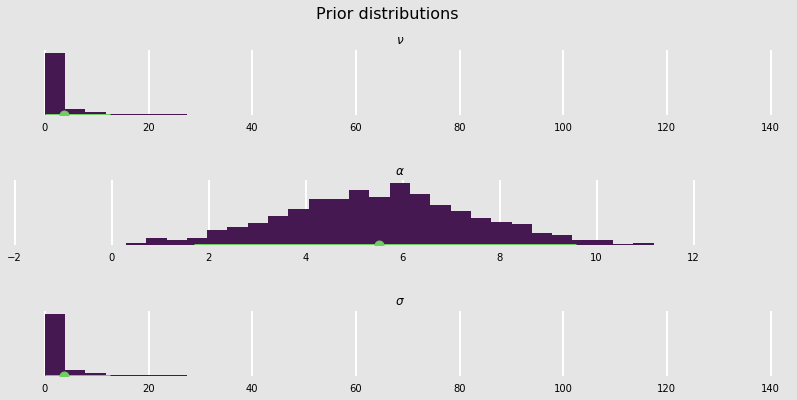

In [281]:
fig, ax = plt.subplots(3, 1, figsize=(14, 6))

t = np.random.standard_cauchy(1000)
ax[0] = posterior_density(ax[0], t[t>0])
ax[0].title.set_text(r'$\nu$')
ax[1] = posterior_density(ax[1], np.random.normal(5.5, 2, 1000))
ax[1].title.set_text(r'$\alpha$')
ax[2] = posterior_density(ax[2], t[t>0])
ax[2].title.set_text("$\sigma$")

fig.set_facecolor(color = "#E5E5E5")
for sp in ax:
    sp.spines['right'].set_visible(False)
    sp.spines['top'].set_visible(False)
    sp.spines['bottom'].set_visible(False)
    sp.spines['left'].set_visible(False)
    sp.xaxis.set_ticks_position("none")
    sp.yaxis.set_ticks_position("none")
    sp.set_facecolor(color = "#E5E5E5")
    sp.grid(True, which = "major", axis = "x", color = "white", lw = 2, zorder = 0)
    sp.set_yticks([])
fig.subplots_adjust(hspace=1)
fig.suptitle('Prior distributions', fontsize = 16)
plt.show()

In [250]:
fd = open(cwd + "/BEST.stan", "r")
stan_code = fd.read()
fd.close()
print(stan_code)

/*
  Author: Rishi Sadhir
  Date: 10/19/2019

  This program tests multi group difference based hypotheses
  using a t distribution to make these diferences more robust to
  outliers. The program is robust to each group having different
  variances.

  Posterior differences are calculated for the first two groups by default.
  Additional contrasts need to be calculated externally.
 */

data {
  // Metadata
  int<lower=1> N;                           // Sample size
  int<lower=2> N_groups;                    // Number of groups

  // Observed data
  vector[N] outcome;                        // Outcome variable
  int<lower=1, upper=N_groups> group_id[N]; // Group variable
}

transformed data {
  real mean_outcome;
  real sd_outcome;
  mean_outcome = mean(outcome);
  sd_outcome = sd(outcome);
}

parameters {
  vector[N_groups] alpha;              // Group means
  vector<lower=0>[N_groups] gamma;     // Group std. deviations
  real<lower=0, upper=100> nu;         // df for t distribution
}

In [251]:
df["genre"] = pd.Categorical(df["genre"])
data_dict = {
    "N": df.shape[0],
    "N_groups": df["genre"].nunique(),
    "outcome": df["rating"],
    "group_id": df["genre"].cat.codes+1
}
sm = ps.StanModel(model_code = stan_code)
fit = sm.sampling(data=data_dict, chains=4, n_jobs=4)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8a15163489d594c532fbad874b60aac3 NOW.


Inference for Stan model: anon_model_8a15163489d594c532fbad874b60aac3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]     5.26  1.8e-3   0.11   5.04   5.18   5.26   5.34   5.49   3908    1.0
alpha[2]     6.22  1.5e-3    0.1   6.04   6.16   6.22   6.29   6.41   3919    1.0
gamma[1]     1.57  1.4e-3   0.09   1.41   1.51   1.57   1.63   1.75   4086    1.0
gamma[2]     1.31  1.3e-3   0.08   1.17   1.26   1.31   1.36   1.47   3641    1.0
nu           39.1    0.51  22.66  10.01  21.12   33.3   53.0  91.37   1983    1.0
mu_diff     -0.96  2.5e-3   0.15  -1.25  -1.06  -0.97  -0.86  -0.67   3574    1.0
sigma_diff   0.26  1.7e-3   0.11   0.05   0.18   0.26   0.33   0.48   4424    1.0
lp__       -502.8    0.04   1.59 -506.7 -503.6 -502.5 -501.6 -500.6   1596    1.0

Samples were drawn using NUTS at Sun Oct 20 13:04:03 2019.
For each para

In [252]:
ps.diagnostics.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

# Analysis

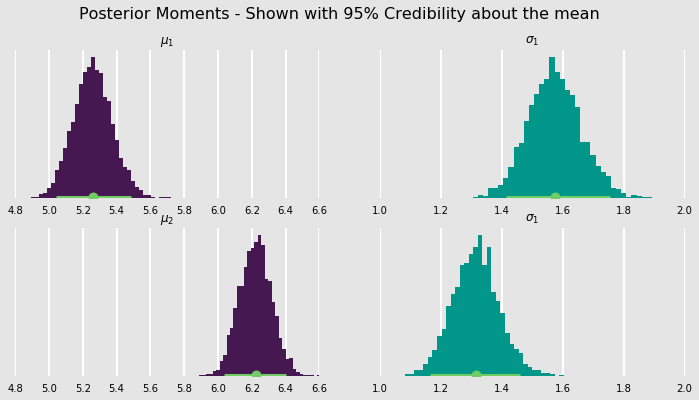

In [277]:
post = fit.extract(["alpha", "gamma"])

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

ax[0,0] = posterior_density(ax[0,0], [i for i,j in post['alpha']])
ax[0,0].title.set_text('$\mu_1$')
ax[0,0].set_xlim(left = 4.8, right = 6.6)
ax[1,0] = posterior_density(ax[1,0], [j for i,j in post['alpha']])
ax[1,0].title.set_text('$\mu_2$')
ax[1,0].set_xlim(left = 4.8, right = 6.6)

ax[0,1] = posterior_density(ax[0,1], [i for i,j in post['gamma']],
                           c =  "#00968A")
ax[0,1].title.set_text('$\sigma_1$')
ax[0,1].set_xlim(left = 1, right = 2)

ax[1,1] = posterior_density(ax[1,1], [j for i,j in post['gamma']],
                           c = "#00968A")
ax[1,1].title.set_text('$\sigma_1$')
ax[1,1].set_xlim(left = 1, right = 2)

fig.set_facecolor(color = "#E5E5E5")
for a in ax:
    for sp in a:
        sp.spines['right'].set_visible(False)
        sp.spines['top'].set_visible(False)
        sp.spines['bottom'].set_visible(False)
        sp.spines['left'].set_visible(False)
        sp.xaxis.set_ticks_position("none")
        sp.yaxis.set_ticks_position("none")
        sp.set_facecolor(color = "#E5E5E5")
        sp.grid(True, which = "major", axis = "x", color = "white", lw = 2, zorder = 0)
        sp.set_yticks([])

fig.suptitle('Posterior Moments - Shown with 95% Credibility about the mean', fontsize = 16)

plt.show()

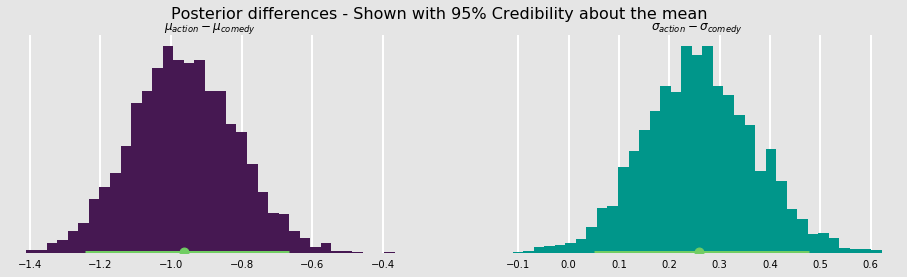

In [275]:
post = fit.extract(["mu_diff", "sigma_diff"])
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0] = posterior_density(ax[0], post["mu_diff"])
ax[0].title.set_text('$\mu_{action} - \mu_{comedy}$')

ax[1] = posterior_density(ax[1], post["sigma_diff"], c = "#00968A")
ax[1].title.set_text('$\sigma_{action} - \sigma_{comedy}$')
fig.suptitle('Posterior differences - Shown with 95% Credibility about the mean', fontsize = 16)
fig.set_facecolor(color = "#E5E5E5")
for sp in ax:
    sp.spines['right'].set_visible(False)
    sp.spines['top'].set_visible(False)
    sp.spines['bottom'].set_visible(False)
    sp.spines['left'].set_visible(False)
    sp.xaxis.set_ticks_position("none")
    sp.yaxis.set_ticks_position("none")
    sp.set_facecolor(color = "#E5E5E5")
    sp.grid(True, which = "major", axis = "x", color = "white", lw = 2, zorder=0)
    sp.set_yticks([])

plt.show()

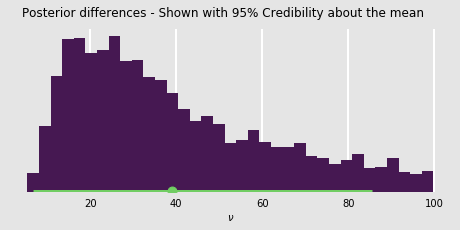

In [279]:
post = fit.extract("nu")
fig, ax = plt.subplots(1,1,figsize = (8, 3))
fig.set_facecolor(color = "#E5E5E5")

ax = posterior_density(ax, post["nu"])
ax.set_xlabel(r'$\nu$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.set_facecolor(color = "#E5E5E5")
ax.grid(True, which = "major", axis = "x", color = "white", lw = 2, zorder = 0)
ax.set_yticks([])
fig.suptitle('Posterior differences - Shown with 95% Credibility about the mean')
plt.show()

# T-Test

In [261]:
from scipy.stats import ttest_ind

In [266]:
action_rating = df[df["genre"] == "Action"]["rating"]
comedy_rating = df[df["genre"] == "Comedy"]["rating"]
ttest_ind(action_rating, comedy_rating)

Ttest_indResult(statistic=-6.439437447124793, pvalue=3.459466276680078e-10)